In [1]:
import numpy
import sys
sys.path.insert(0, '../Isomap/')

from manifold import KNNgraph
from scipy.spatial.distance import cdist
from sklearn.utils.graph_shortest_path import graph_shortest_path

In [373]:
class SpectralEmb():
    
    
    def __init__(self,X,num_dim=2,k = 5,dist_func = 'euclidean',eps = None):
        self.X = X
        self.d = num_dim
        self.k = k #K-neighbours
        self.metric = dist_func
        
        if eps!=None:
            self.distance_matrix = self._make_adjacency_eps(eps = eps)
        else:
            self.distance_matrix = self._make_adjacency_knn()
        #print(self.distance_matrix)
        
        
    
    
    def _make_adjacency_eps(self, eps=1):
        
        
        """
        Step one of ISOMAP algorithm, make Adjacency and distance matrix
        Compute the WEIGHTED adjacency matrix A from the given data points.  Points
        are considered neighbors if they are within epsilon of each other.  Distance
        between points will be calculated using SciPy's cdist which will
        compute the D matrix for us. 
        INPUT
        ------
         data - (ndarray) the dataset which should be a numpy array
         dist_func - (str) the distance metric to use. See SciPy cdist for list of
                     options
         eps - (int/float) epsilon value to define the local region. I.e. two points
                           are connected if they are within epsilon of each other.
        OUTPUT
        ------
         short - (ndarray) Distance matrix, the shortest path from every point to
             every other point in the set, INF if not reachable. 
        """
    
        n, d = self.X.shape
        dist = cdist(self.X,self.X, metric=self.metric)
        adj =  np.zeros((n, n)) + np.inf
        bln = dist < eps
        print(bln)
        adj[bln] = dist[bln]
        print(adj)
        short = graph_shortest_path(adj)
        print(short)

        return short
    
    def _make_adjacency_knn(self):
    
        knn_graph = KNNgraph(self.X,self.k,dist_metric = self.metric)
        partial_adj = knn_graph.create_graph()
        
        m = knn_graph.create_graph()
        n = m.T
        partial_adj[m == 0] = n[m == 0]
        dis_adj = partial_adj
#         dis_adj = np.exp(1/40 * dis_adj**2)
#         dis_adj = np.reciprocal(dis_adj,where=dis_adj!=0)

        
        return dis_adj
    
    def adjacency_matrix(self):
        dis_adj = self._make_adjacency_knn()
        dis_adj[dis_adj>0] = 1
        return dis_adj
        return self._make_adjacency_knn()
    
    def degree_matrix(self):
        degrees = self.adjacency_matrix().sum(axis = 1)
        D = np.diag(degrees)
        return D
    
    def laplacian_matrix(self):
        L = self.adjacency_matrix() - self.degree_matrix()
        return L



    def project(self,normalization = True):


        """
        take an adjacency matrix and distance matrix and compute the ISOMAP
        algorithm

        Take the shortest path distance matrix. This follows from the algorithm in
        class, create a centering matrix and apply it to the distance matrix D. Then
        we can compute the C matrix which will be used for the eigen-decomposion
        Find out more 

        INPUT
        ------
          d - (ndarray) Distance matrix between nodes. Should be square.
          dim - (int) how many dimensions to reduce down too

        OUTPUT
        ------
          z - (ndarray) data projection into new reduced space. Each row maps back
              to one of the origional datapoints
        """
    
    
        L = self.laplacian_matrix()
        
        if normalization:
            D = self.degree_matrix()
            self.D_1_2 = np.linalg.inv(D)**1/2
            L_normalized = self.D_1_2 @ L @ self.D_1_2
            L = L_normalized
        
        w,v = np.linalg.eig(L)
        print(w)
        
        k = np.array([x for _, x in sorted(zip(w, v.T), key=lambda pair: pair[0],reverse= True)]).T
        
        if normalization:
            k = k
        
        embeddings = k[:,1:self.d +1]
        return embeddings,k
        
        
        
        
#         if technique == 'mds':
#             mds = MDS(self.X,self.d,G=-0.5*self.distance_matrix**2)
#             proj = mds.project()
            
#         elif technique == 'kpca':
#             kpca = KPCA(None,None,self.d,G =-0.5*self.distance_matrix**2 )
#             proj = kpca.project()
#             proj = proj.T

#         return proj

In [374]:
import numpy as np
X = np.array([[1,2],[7,8],[5,6],[3,4]])

knn = KNNgraph(X,2)
#knn.find_neighbours()
m = knn.create_graph()

In [375]:
m[m>0] = 1

In [376]:
m

array([[0., 0., 1., 1.],
       [0., 0., 1., 1.],
       [0., 1., 0., 1.],
       [1., 0., 1., 0.]])

In [377]:
degrees = m.sum(axis = 1)

In [378]:
D = np.diag(degrees)

In [379]:
L = D-m

In [380]:
L

array([[ 2.,  0., -1., -1.],
       [ 0.,  2., -1., -1.],
       [ 0., -1.,  2., -1.],
       [-1.,  0., -1.,  2.]])

In [381]:
from sklearn.datasets import load_digits
digits = load_digits()


X,y = digits['data'], digits['target']

In [382]:
im = SpectralEmb(X,num_dim = 2,k = 10)

In [383]:
e,k = im.project(normalization = True)

[-5.00372071e-21 -1.42088769e-04 -1.42054629e-04 ... -1.39931827e-04
 -1.39908420e-04 -1.39909206e-04]


In [384]:
e.shape

(1797, 2)

In [385]:
k

array([[-6.61413476e-06, -1.25593724e-07, -2.32786989e-06, ...,
         9.16048513e-06,  1.33676539e-05,  4.15839264e-06],
       [-6.61413476e-06,  6.18967209e-06, -2.10195189e-06, ...,
        -2.80418547e-06, -8.33555801e-07,  4.60479631e-07],
       [-6.61413476e-06,  1.76158374e-06,  9.59454248e-06, ...,
        -6.90199918e-07, -2.43531692e-07,  1.58392378e-07],
       ...,
       [-6.61413476e-06, -2.09526711e-06, -6.12290510e-06, ...,
        -1.52730436e-06, -5.11964992e-07,  2.95418185e-07],
       [-6.61413476e-06,  1.23918869e-06, -2.13972359e-06, ...,
        -1.68403830e-06, -6.15147746e-07,  3.43752166e-07],
       [-6.61413476e-06,  1.18366995e-06,  9.34420286e-06, ...,
        -9.84817556e-07, -4.26903943e-07,  2.35066980e-07]])

In [386]:
im.degree_matrix()

array([[1778.12361063,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        , 1785.0065296 ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        , 1785.00050085, ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [   0.        ,    0.        ,    0.        , ..., 1786.00003492,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
        1784.0000905 ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        , 1786.00002633]])

In [387]:
im.laplacian_matrix()

array([[-1.77712361e+03,  1.00000000e+00,  1.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 1.00000000e+00, -1.78400653e+03,  1.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 1.00000000e+00,  1.00000000e+00, -1.78400050e+03, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       ...,
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
        -1.78500003e+03,  1.00000000e+00,  8.80967835e-10],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         1.00000000e+00, -1.78300009e+03,  1.00000000e+00],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         8.80967835e-10,  1.00000000e+00, -1.78500003e+03]])

In [388]:
im.adjacency_matrix().shape

(1797, 1797)

In [389]:
np.linalg.inv(im.degree_matrix())**1/2

array([[0.0002812 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00028011, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00028011, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00027996, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00028027,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00027996]])

In [390]:
w,v = np.linalg.eig(X[:2,:2])

In [391]:
v

array([[1., 0.],
       [0., 1.]])

In [392]:
w = np.array([0,5,4,2])
v = np.array([[1,2,3,4],[4,5,6,7],[7,8,9,10],[10,11,12,13]])

In [393]:
np.argsort(w)

array([0, 3, 2, 1], dtype=int64)

In [394]:
help(sorted)

Help on built-in function sorted in module builtins:

sorted(iterable, /, *, key=None, reverse=False)
    Return a new list containing all items from the iterable in ascending order.
    
    A custom key function can be supplied to customize the sort order, and the
    reverse flag can be set to request the result in descending order.



In [395]:
 k = np.array([x for _, x in sorted(zip(w, v.T), key=lambda pair: pair[0])])

In [396]:
k.T

array([[ 1,  4,  3,  2],
       [ 4,  7,  6,  5],
       [ 7, 10,  9,  8],
       [10, 13, 12, 11]])

In [397]:
len(X_im)

1797

In [398]:
colors = []
X_im,_ = im.project(normalization = True)
X_ = []
X_t = []
y_ = []
for i in range(len(y)):
    if y[i] == 1:
        X_.append(X_im[i])
        y_.append(1)
        colors.append('#FFB300')
    elif y[i] == 2:
        X_.append(X_im[i])
        y_.append(2)
        colors.append('#E64A19')


[-5.00372071e-21 -1.42088769e-04 -1.42054629e-04 ... -1.39931827e-04
 -1.39908420e-04 -1.39909206e-04]


In [399]:
X_im

array([[-1.25593724e-07, -2.32786989e-06],
       [ 6.18967209e-06, -2.10195189e-06],
       [ 1.76158374e-06,  9.59454248e-06],
       ...,
       [-2.09526711e-06, -6.12290510e-06],
       [ 1.23918869e-06, -2.13972359e-06],
       [ 1.18366995e-06,  9.34420286e-06]])

In [400]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

def plot_scores_2d(data, colors, grid = True, dim_1 = 1, dim_2 = 2):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(15,10))
    plt.axhline(c = 'black', alpha = 0.2)
    plt.axvline(c = 'black', alpha = 0.2)
    plt.scatter(data.T[dim_1 - 1,:], data.T[dim_2 - 1,:], c = colors)
    plt.grid(grid)
    plt.title('Spectral Projection')
    plt.xlabel('{}st dimension'.format(dim_1))
    plt.ylabel('{}nd dimension'.format(dim_2))
    plt.show()

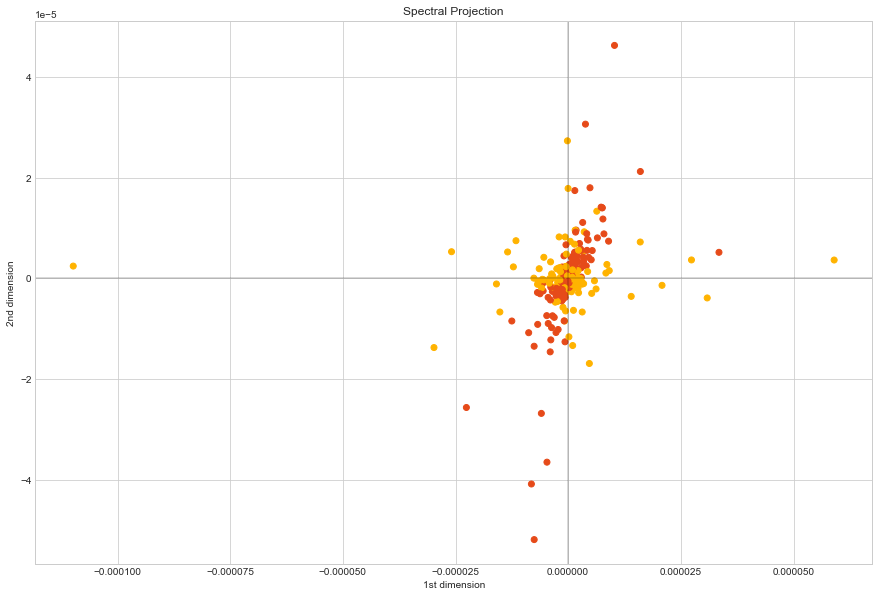

In [401]:
plot_scores_2d(np.array(X_),colors)

In [32]:
>>> from sklearn.datasets import load_digits
>>> from sklearn.manifold import SpectralEmbedding
>>> X, _ = load_digits(return_X_y=True)
>>> X.shape
(1797, 64)
>>> embedding = SpectralEmbedding(n_components=2)
>>> X_transformed = embedding.fit_transform(X)
>>> X_transformed.shape

(1797, 2)

In [33]:
X_transformed

array([[ 4.01478344e-03, -2.09148890e-03],
       [-1.01835315e-03,  1.26762334e-03],
       [-1.07847176e-03,  8.51272305e-04],
       ...,
       [-7.94351044e-04,  9.30524958e-04],
       [ 1.13736296e-04, -1.53286884e-03],
       [-2.94861578e-05,  2.62299231e-04]])

In [34]:
colors = []
X_im=X_transformed
X_ = []
X_t = []
y_ = []
for i in range(len(y)):
    if y[i] == 1:
        X_.append(X_im[i])
        y_.append(1)
        colors.append('#FFB300')
    elif y[i] == 2:
        X_.append(X_im[i])
        y_.append(2)
        colors.append('#E64A19')

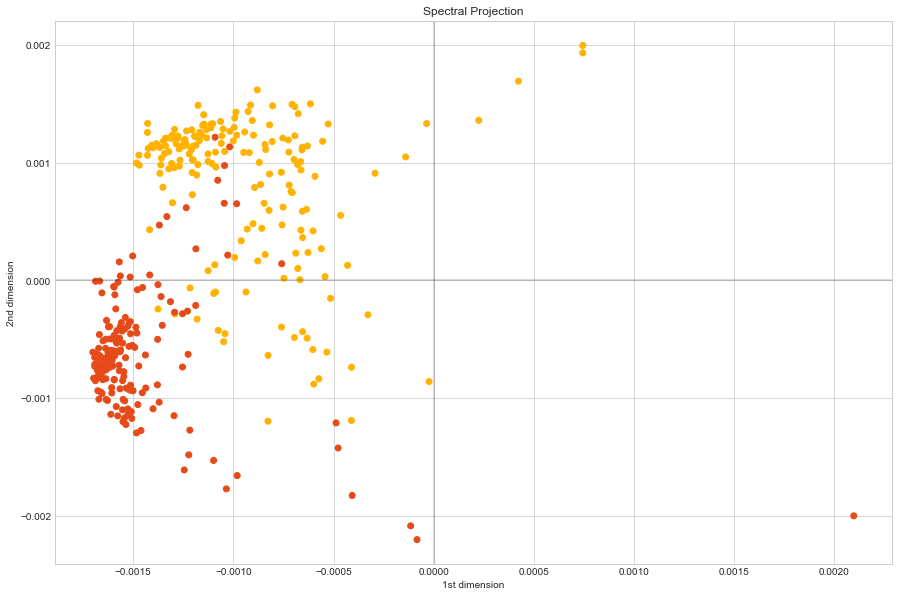

In [35]:
plot_scores_2d(np.array(X_),colors)